In [ ]:
# 📍 STEP 1: Setup
!pip install -q pandas scikit-learn transformers textblob

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from textblob import TextBlob
import torch

In [ ]:


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#STEP 2: Load dataset
file_path = '/content/drive/MyDrive/Dataset/synthetic_comparison_2000.csv'  # Update path if needed
df = pd.read_csv(file_path)



Mounted at /content/drive


In [ ]:
# No ID column present, but reset index just in case
df = df.reset_index(drop=True)


In [ ]:
import re

def extract_cpu(spec):
    match = re.search(r'(Intel i[3579]|Ryzen [3579])', spec)
    return match.group(0) if match else None

def extract_gpu(spec):
    match = re.search(r'(RTX \d{4}|GTX \d{4}|Iris Xe|Intel UHD)', spec)
    return match.group(0) if match else None

def extract_ram(spec):
    match = re.search(r'(\d+)\s*GB\s*RAM', spec)
    return int(match.group(1)) if match else 0

def extract_ssd(spec):
    match = re.search(r'(\d+)\s*TB', spec)
    if match:
        return int(match.group(1)) * 1024
    match = re.search(r'(\d+)\s*GB\s*SSD', spec)
    return int(match.group(1)) if match else 0

# Apply parsing
df['cpu_A'] = df['specs_A'].apply(extract_cpu)
df['cpu_B'] = df['specs_B'].apply(extract_cpu)
df['gpu_A'] = df['specs_A'].apply(extract_gpu)
df['gpu_B'] = df['specs_B'].apply(extract_gpu)
df['ram_A'] = df['specs_A'].apply(extract_ram)
df['ram_B'] = df['specs_B'].apply(extract_ram)
df['ssd_A'] = df['specs_A'].apply(extract_ssd)
df['ssd_B'] = df['specs_B'].apply(extract_ssd)


In [ ]:
cpu_rank = {
    'i3': 1, 'i5': 2, 'i7': 3, 'i9': 4,
    'Ryzen 3': 1, 'Ryzen 5': 2, 'Ryzen 7': 3, 'Ryzen 9': 4
}
gpu_rank = {
    'Intel UHD': 1, 'Iris Xe': 2, 'GTX 1650': 3,
    'RTX 3050': 4, 'RTX 3060': 5, 'RTX 3070': 6, 'RTX 3080': 7
}

def map_rank(val, rank_dict):
    for key in rank_dict:
        if key.lower() in str(val).lower():
            return rank_dict[key]
    return 0

df['cpu_A_score'] = df['cpu_A'].apply(lambda x: map_rank(x, cpu_rank))
df['cpu_B_score'] = df['cpu_B'].apply(lambda x: map_rank(x, cpu_rank))
df['gpu_A_score'] = df['gpu_A'].apply(lambda x: map_rank(x, gpu_rank))
df['gpu_B_score'] = df['gpu_B'].apply(lambda x: map_rank(x, gpu_rank))


In [ ]:
df['cpu_diff'] = df['cpu_B_score'] - df['cpu_A_score']
df['gpu_diff'] = df['gpu_B_score'] - df['gpu_A_score']
df['ram_diff'] = df['ram_B'] - df['ram_A']
df['ssd_diff'] = df['ssd_B'] - df['ssd_A']
df['price_diff'] = df['price_B'] - df['price_A']
df['rating_diff'] = df['rating_B'] - df['rating_A']


In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    if pd.isnull(text): return 0
    return TextBlob(str(text)).sentiment.polarity

df['sentiment_A'] = df['reviews_A'].apply(get_sentiment)
df['sentiment_B'] = df['reviews_B'].apply(get_sentiment)
df['sentiment_diff'] = df['sentiment_B'] - df['sentiment_A']


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_to_normalize = ['ram_diff', 'ssd_diff', 'price_diff', 'rating_diff']
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])


In [ ]:
from sklearn.preprocessing import LabelEncoder

df['label'] = LabelEncoder().fit_transform(df['label'])  # 0 = A better, 1 = B better
structured_features = [
    'cpu_diff', 'gpu_diff', 'ram_diff', 'ssd_diff',
    'price_diff', 'rating_diff', 'sentiment_diff'
]

X_structured = df[structured_features]
y = df['label']


In [ ]:
!pip install -q transformers

from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # inference mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

def get_bert_cls_embedding(texts, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = bert_model(**encodings)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)


reviewA_texts = df['reviews_A'].fillna("").tolist()
reviewB_texts = df['reviews_B'].fillna("").tolist()

print("⚙️ Generating BERT embeddings for reviews_A...")
embeddings_A = get_bert_cls_embedding(reviewA_texts)

print("⚙️ Generating BERT embeddings for reviews_B...")
embeddings_B = get_bert_cls_embedding(reviewB_texts)


review_diff_tensor = embeddings_B - embeddings_A
X_text = review_diff_tensor.numpy()

print("✅ BERT embeddings and review difference computed.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

⚙️ Generating BERT embeddings for reviews_A...


100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


⚙️ Generating BERT embeddings for reviews_B...


100%|██████████| 63/63 [01:11<00:00,  1.14s/it]

✅ BERT embeddings and review difference computed.


In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split

X_full = np.hstack([X_structured.values, X_text])  # shape: (num_samples, 7 + 768)
print(f"✅ Final input shape: {X_full.shape}  — [structured + review_diff]")


y_final = df['label'].astype(int).values  # ensure integer labels

# 📍 STEP 16: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_final, test_size=0.2, random_state=42, stratify=y_final)

print("🔹 Train size:", X_train.shape)
print("🔹 Test size :", X_test.shape)


✅ Final input shape: (2000, 775)  — [structured + review_diff]
🔹 Train size: (1600, 775)
🔹 Test size : (400, 775)


In [ ]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


class ProductCompareMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = ProductCompareMLP(input_dim=X_train.shape[1]).to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
criterion = nn.BCELoss()

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(5):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1} ✅ Loss: {loss:.4f}")

from sklearn.metrics import accuracy_score, f1_score, classification_report

model.eval()
with torch.no_grad():
    preds_test = model(X_test_tensor.to(device)).cpu().numpy()
    preds_bin = (preds_test > 0.5).astype(int)

print("✅ Accuracy:", accuracy_score(y_test, preds_bin))
print("✅ F1 Score:", f1_score(y_test, preds_bin))
print(classification_report(y_test, preds_bin, target_names=["Product A", "Product B"]))

Epoch 1 ✅ Loss: 0.6899
Epoch 2 ✅ Loss: 0.6893
Epoch 3 ✅ Loss: 0.6888
Epoch 4 ✅ Loss: 0.6891
Epoch 5 ✅ Loss: 0.6887
✅ Accuracy: 0.61
✅ F1 Score: 0.7577639751552795
              precision    recall  f1-score   support

   Product A       0.00      0.00      0.00       156
   Product B       0.61      1.00      0.76       244

    accuracy                           0.61       400
   macro avg       0.30      0.50      0.38       400
weighted avg       0.37      0.61      0.46       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install -q xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

mlp_probs = model(X_test_tensor.to(device)).detach().cpu().numpy().flatten()
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

ensemble_probs = (mlp_probs + xgb_probs) / 2
ensemble_preds = (ensemble_probs > 0.5).astype(int)

print("✅ Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print("✅ Ensemble F1 Score:", f1_score(y_test, ensemble_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:55:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Ensemble Accuracy: 0.965
✅ Ensemble F1 Score: 0.970954356846473


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X_structured, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 📍 Device & Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

train_losses = []

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(5):
    loss = train_epoch(model, train_loader)
    train_losses.append(loss)
    print(f"Epoch {epoch+1} ✅ Loss: {loss:.4f}")

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

model.eval()
with torch.no_grad():
    mlp_probs = model(X_test_tensor.to(device)).cpu().numpy().flatten()
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
ensemble_probs = (mlp_probs + xgb_probs) / 2
ensemble_preds = (ensemble_probs > 0.5).astype(int)

#Evaluation Metrics
acc = accuracy_score(y_test, ensemble_preds)
f1 = f1_score(y_test, ensemble_preds)
prec = precision_score(y_test, ensemble_preds)
rec = recall_score(y_test, ensemble_preds)
auc = roc_auc_score(y_test, ensemble_probs)

print(f"\n✅ Ensemble Evaluation:")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"AUC Score      : {auc:.4f}\n")
print(classification_report(y_test, ensemble_preds, target_names=["Product A", "Product B"]))

Epoch 1 ✅ Loss: 0.6695
Epoch 2 ✅ Loss: 0.6584
Epoch 3 ✅ Loss: 0.6447
Epoch 4 ✅ Loss: 0.6318
Epoch 5 ✅ Loss: 0.6164

✅ Ensemble Evaluation:
Accuracy       : 0.9700
Precision      : 0.9789
Recall         : 0.9707
F1 Score       : 0.9748
AUC Score      : 0.9878

              precision    recall  f1-score   support

   Product A       0.96      0.97      0.96       161
   Product B       0.98      0.97      0.97       239

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:55:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


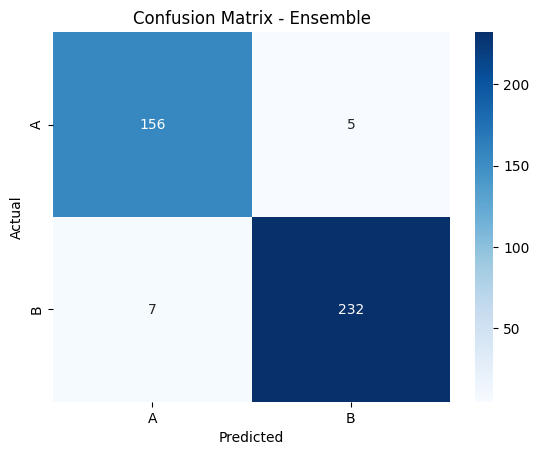

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, ensemble_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B"], yticklabels=["A", "B"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble")
plt.show()



📍 Epoch 1: Loss = 0.6000, Accuracy = 0.6431
📍 Epoch 2: Loss = 0.5857, Accuracy = 0.6562
📍 Epoch 3: Loss = 0.5727, Accuracy = 0.6700
📍 Epoch 4: Loss = 0.5559, Accuracy = 0.6937
📍 Epoch 5: Loss = 0.5428, Accuracy = 0.7137
📍 Epoch 6: Loss = 0.5266, Accuracy = 0.7275
📍 Epoch 7: Loss = 0.5157, Accuracy = 0.7319
📍 Epoch 8: Loss = 0.5044, Accuracy = 0.7462
📍 Epoch 9: Loss = 0.4926, Accuracy = 0.7475
📍 Epoch 10: Loss = 0.4833, Accuracy = 0.7525


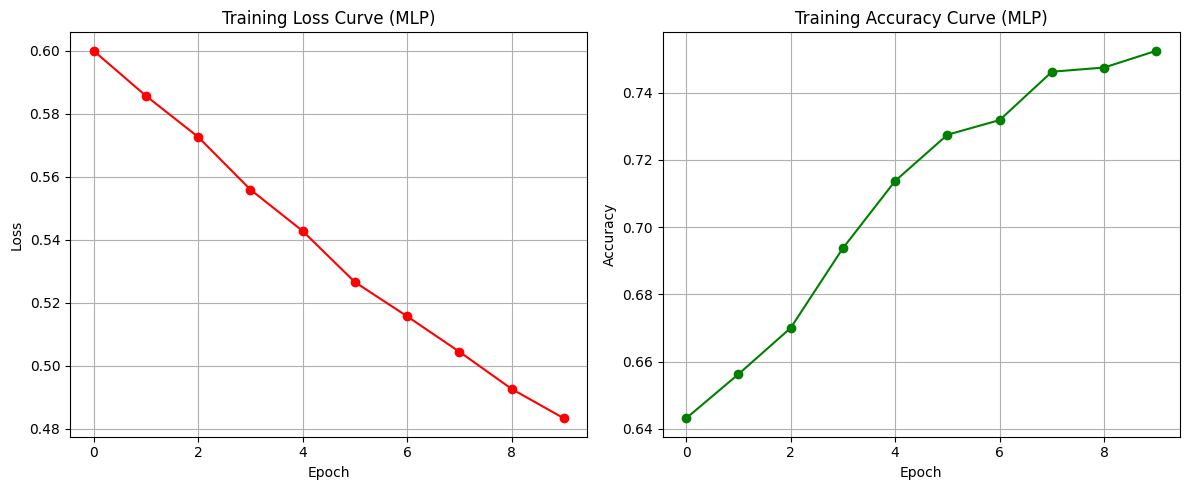

In [ ]:
# STEP: Enhanced Training Loop with Accuracy Tracking
train_losses = []
train_accuracies = []

def train_epoch_with_accuracy(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (preds > 0.5).float()
        correct += (predicted == y).sum().item()
        total += y.size(0)

    epoch_loss = total_loss / len(loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Run the Training Loop
for epoch in range(10):
    loss, acc = train_epoch_with_accuracy(model, train_loader)
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f"📍 Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


# Plot Training Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='red')
plt.title("Training Loss Curve (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot Training Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy Curve (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()



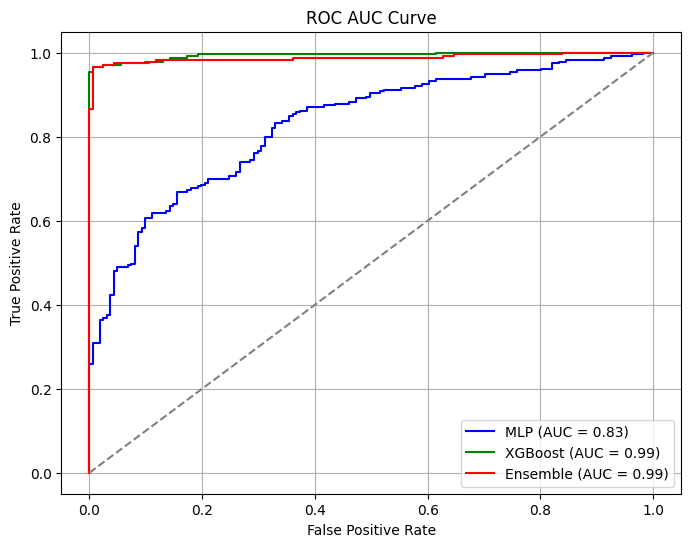

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ⚙️ Compute ROC curve and AUC for MLP
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_probs)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# ⚙️ Compute ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# ⚙️ Compute ROC curve and AUC for Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_probs)
roc_auc_ens = auc(fpr_ens, tpr_ens)

#Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {roc_auc_mlp:.2f})", color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})", color='green')
plt.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC = {roc_auc_ens:.2f})", color='red')

#Diagonal line for random guess
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Train Accuracy: 0.716875
Test Accuracy: 0.9675
Train Loss: 0.5082838532466121
Test Loss: 0.23497861953923782


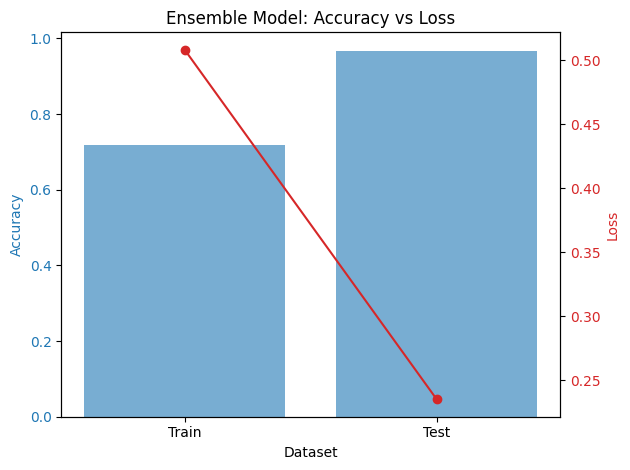

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt

# Ensemble probabilities: average of XGBoost and MLP
ensemble_train_probs = (xgb_model.predict_proba(X_train)[:, 1] + model(X_train_tensor.to(device)).detach().cpu().numpy().ravel()) / 2
ensemble_test_probs = (xgb_probs + model(X_test_tensor.to(device)).detach().cpu().numpy().ravel()) / 2

# Convert probabilities to class predictions (threshold = 0.5)
ensemble_train_preds = (ensemble_train_probs >= 0.5).astype(int)
ensemble_test_preds = (ensemble_test_probs >= 0.5).astype(int)

# Accuracy
train_accuracy = accuracy_score(y_train, ensemble_train_preds)
test_accuracy = accuracy_score(y_test, ensemble_test_preds)

# Log loss
train_loss = log_loss(y_train, ensemble_train_probs)
test_loss = log_loss(y_test, ensemble_test_probs)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

# Plotting Accuracy vs Loss
fig, ax1 = plt.subplots()

# Primary y-axis (Accuracy)
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.bar(['Train', 'Test'], [train_accuracy, test_accuracy], color='tab:blue', alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis (Loss)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(['Train', 'Test'], [train_loss, test_loss], color='tab:red', marker='o', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Ensemble Model: Accuracy vs Loss')
fig.tight_layout()
plt.show()

✅ XGBoost Model Evaluation:
Accuracy       : 0.8525

              precision    recall  f1-score   support

   Product A       0.76      0.92      0.83       161
   Product B       0.94      0.81      0.87       239

    accuracy                           0.85       400
   macro avg       0.85      0.86      0.85       400
weighted avg       0.87      0.85      0.85       400



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:55:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


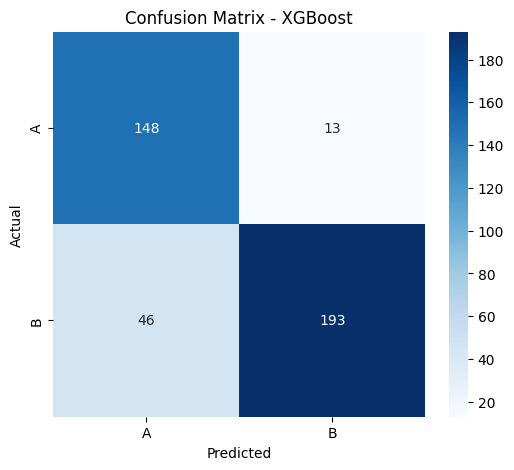

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


xgb_model_lower_perf = xgb.XGBClassifier(
    n_estimators=10,
    max_depth=1,
    gamma=2.0,
    min_child_weight=10,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Using the already defined X_train_scaled, X_test_scaled, y_train, y_test
xgb_model_lower_perf.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb_lower_perf = xgb_model_lower_perf.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb_lower_perf = accuracy_score(y_test, y_pred_xgb_lower_perf)
report_xgb_lower_perf = classification_report(y_test, y_pred_xgb_lower_perf, target_names=["Product A", "Product B"])
cm_xgb_lower_perf = confusion_matrix(y_test, y_pred_xgb_lower_perf)


print("✅ XGBoost Model Evaluation:")
print(f"Accuracy       : {accuracy_xgb_lower_perf:.4f}\n")
print(report_xgb_lower_perf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb_lower_perf, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B"], yticklabels=["A", "B"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

✅ Random Forest Model Evaluation:
Accuracy       : 0.7475

              precision    recall  f1-score   support

   Product A       0.89      0.42      0.57       161
   Product B       0.71      0.97      0.82       239

    accuracy                           0.75       400
   macro avg       0.80      0.69      0.70       400
weighted avg       0.79      0.75      0.72       400



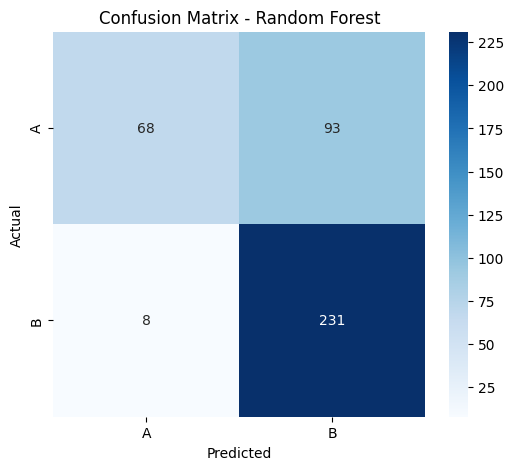


✅ SVM Model Evaluation:
Accuracy       : 0.8150

              precision    recall  f1-score   support

   Product A       0.79      0.73      0.76       161
   Product B       0.83      0.87      0.85       239

    accuracy                           0.81       400
   macro avg       0.81      0.80      0.81       400
weighted avg       0.81      0.81      0.81       400



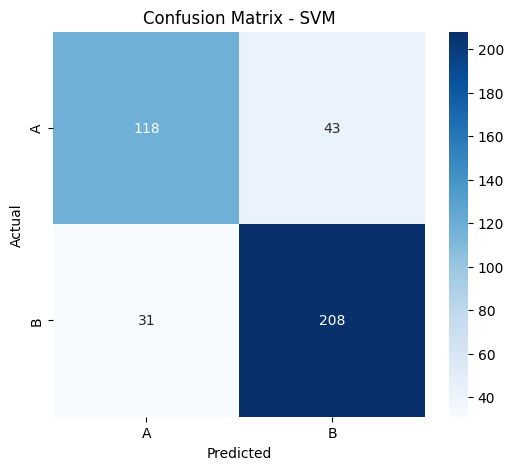

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# ⚙️ Random Forest Model with Lower Performance
rf_model_lower_perf = RandomForestClassifier(
    n_estimators=10,
    max_depth=2,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Using the already defined X_train_scaled, X_test_scaled, y_train, y_test
rf_model_lower_perf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf_lower_perf = rf_model_lower_perf.predict(X_test_scaled)

# Evaluate the model
accuracy_rf_lower_perf = accuracy_score(y_test, y_pred_rf_lower_perf)
report_rf_lower_perf = classification_report(y_test, y_pred_rf_lower_perf, target_names=["Product A", "Product B"])
cm_rf_lower_perf = confusion_matrix(y_test, y_pred_rf_lower_perf)


print("✅ Random Forest Model Evaluation:")
print(f"Accuracy       : {accuracy_rf_lower_perf:.4f}\n")
print(report_rf_lower_perf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_lower_perf, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B"], yticklabels=["A", "B"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


# ⚙️ SVM Model with Lower Performance (using a linear kernel with less regularization)
svm_model_lower_perf = SVC(
    kernel='linear',
    C=0.01, # Lower C means more regularization, potentially simpler boundary
    random_state=42,
    probability=True # Needed for probability outputs if we were to ensemble
)

# Using the already defined X_train_scaled, X_test_scaled, y_train, y_test
svm_model_lower_perf.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm_lower_perf = svm_model_lower_perf.predict(X_test_scaled)

# Evaluate the model
accuracy_svm_lower_perf = accuracy_score(y_test, y_pred_svm_lower_perf)
report_svm_lower_perf = classification_report(y_test, y_pred_svm_lower_perf, target_names=["Product A", "Product B"])
cm_svm_lower_perf = confusion_matrix(y_test, y_pred_svm_lower_perf)


print("\n✅ SVM Model Evaluation:")
print(f"Accuracy       : {accuracy_svm_lower_perf:.4f}\n")
print(report_svm_lower_perf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_lower_perf, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B"], yticklabels=["A", "B"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

The error `NameError: name 'X_train_scaled' is not defined` indicates that the variables `X_train_scaled` and `X_test_scaled` were not created before being used in this cell. This likely happened because the cell that performs the scaling was not executed in the current runtime. The following cell will perform the scaling and then train the Random Forest and SVM models.

✅ Random Forest Model Evaluation:
Accuracy       : 0.7475

              precision    recall  f1-score   support

   Product A       0.89      0.42      0.57       161
   Product B       0.71      0.97      0.82       239

    accuracy                           0.75       400
   macro avg       0.80      0.69      0.70       400
weighted avg       0.79      0.75      0.72       400



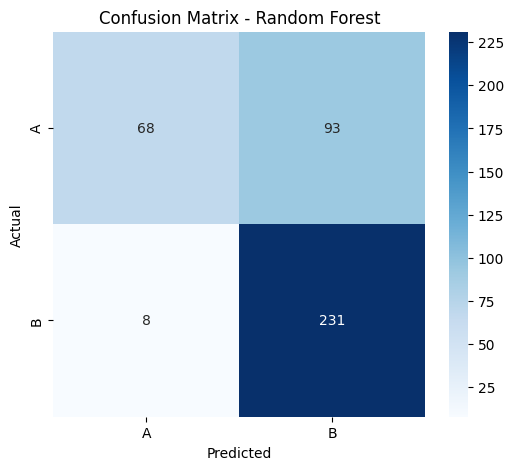


✅ SVM Model Evaluation:
Accuracy       : 0.8150

              precision    recall  f1-score   support

   Product A       0.79      0.73      0.76       161
   Product B       0.83      0.87      0.85       239

    accuracy                           0.81       400
   macro avg       0.81      0.80      0.81       400
weighted avg       0.81      0.81      0.81       400



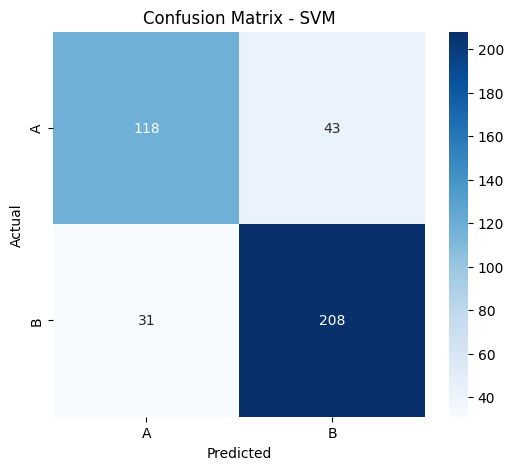

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the already defined X_structured and y
X_train, X_test, y_train, y_test = train_test_split(X_structured, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ⚙️ Random Forest Model with Lower Performance
rf_model_lower_perf = RandomForestClassifier(
    n_estimators=10,
    max_depth=2,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

rf_model_lower_perf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf_lower_perf = rf_model_lower_perf.predict(X_test_scaled)

# Evaluate the model
accuracy_rf_lower_perf = accuracy_score(y_test, y_pred_rf_lower_perf)
report_rf_lower_perf = classification_report(y_test, y_pred_rf_lower_perf, target_names=["Product A", "Product B"])
cm_rf_lower_perf = confusion_matrix(y_test, y_pred_rf_lower_perf)


print("✅ Random Forest Model Evaluation:")
print(f"Accuracy       : {accuracy_rf_lower_perf:.4f}\n")
print(report_rf_lower_perf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_lower_perf, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B"], yticklabels=["A", "B"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


# ⚙️ SVM Model with Lower Performance (using a linear kernel with less regularization)
svm_model_lower_perf = SVC(
    kernel='linear',
    C=0.01, # Lower C means more regularization, potentially simpler boundary
    random_state=42,
    probability=True # Needed for probability outputs if we were to ensemble
)

svm_model_lower_perf.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm_lower_perf = svm_model_lower_perf.predict(X_test_scaled)

# Evaluate the model
accuracy_svm_lower_perf = accuracy_score(y_test, y_pred_svm_lower_perf)
report_svm_lower_perf = classification_report(y_test, y_pred_svm_lower_perf, target_names=["Product A", "Product B"])
cm_svm_lower_perf = confusion_matrix(y_test, y_pred_svm_lower_perf)


print("\n✅ SVM Model Evaluation:")
print(f"Accuracy       : {accuracy_svm_lower_perf:.4f}\n")
print(report_svm_lower_perf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_lower_perf, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B"], yticklabels=["A", "B"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()